# HDR Plot - an example with 3 components

The *El Niño* dataset consists of 60 years worth of averaged monthly sea surface temperature (SST) in degrees Celcius of the Pacific Ocean at 0-10 deg South and 90-80 deg West between 1950 and 2007.
Years 1982-83 and 1997-98 are outliers; these are the years where *El Niño* (a climate pattern characterized by warming up of the sea surface and higher air pressures) occurred with unusual intensity.

Source: NOAA - ERSSTv5 - Nino 1+2 at http://www.cpc.ncep.noaa.gov/data/indices/

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import openturns as ot
from openturns.viewer import View
from othdrplot import ProcessHighDensityRegionAlgorithm

The minimum volume level set computation requires a sampling which can be costly with the default value of the parameters, due to a huge sampling size. Hence, we reduce it to 500.

In [2]:
n_samples = 500
ot.ResourceMap.Set('Distribution-MinimumVolumeLevelSetBySampling', 'true')
ot.ResourceMap.Set('Distribution-MinimumVolumeLevelSetSamplingSize', str(n_samples))

Load the dataset.

In [3]:
fname = os.path.join(os.path.abspath(''), '../../tests/data/npfda-elnino.dat')
separatorstr = " "
data = ot.Sample.ImportFromTextFile(fname,separatorstr)

Create the mesh.

In [4]:
print("Number of dates : %d" % (data.getDimension()))
print("Number of fields : %d" % (data.getSize()))

Number of dates : 12
Number of fields : 54


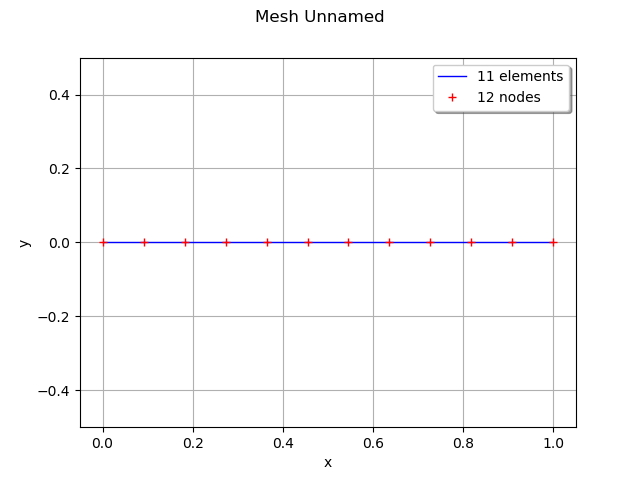

In [5]:
n_nodes = data.getDimension()
mesher = ot.IntervalMesher([n_nodes - 1])
interval = ot.Interval([0.0], [1.0])
mesh = mesher.build(interval)
mesh.draw()

Create the `ProcessSample` from the data.

In [6]:
n_fields = data.getSize()
d_fields = 1
sample = ot.ProcessSample(mesh, n_fields, d_fields)
for i in range(n_fields):
    trajectory = ot.Sample(data[i, :], 1)
    sample[i] = ot.Field(mesh, trajectory)

Compute HDRPlot: in this example, we set the number of components to 3.

In [7]:
hdr = ProcessHighDensityRegionAlgorithm(sample)
hdr.setContoursAlpha([0.7, 0.5])
hdr.setOutlierAlpha(0.7)
hdr.setThreshold(0.05)
hdr.run()
hdr.summary()

Number of trajectories = 54
Number of vertices = 12


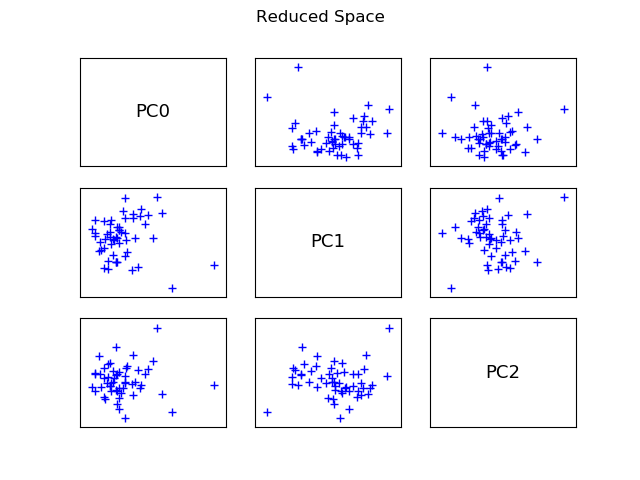

In [8]:
hdr.drawDimensionReduction()

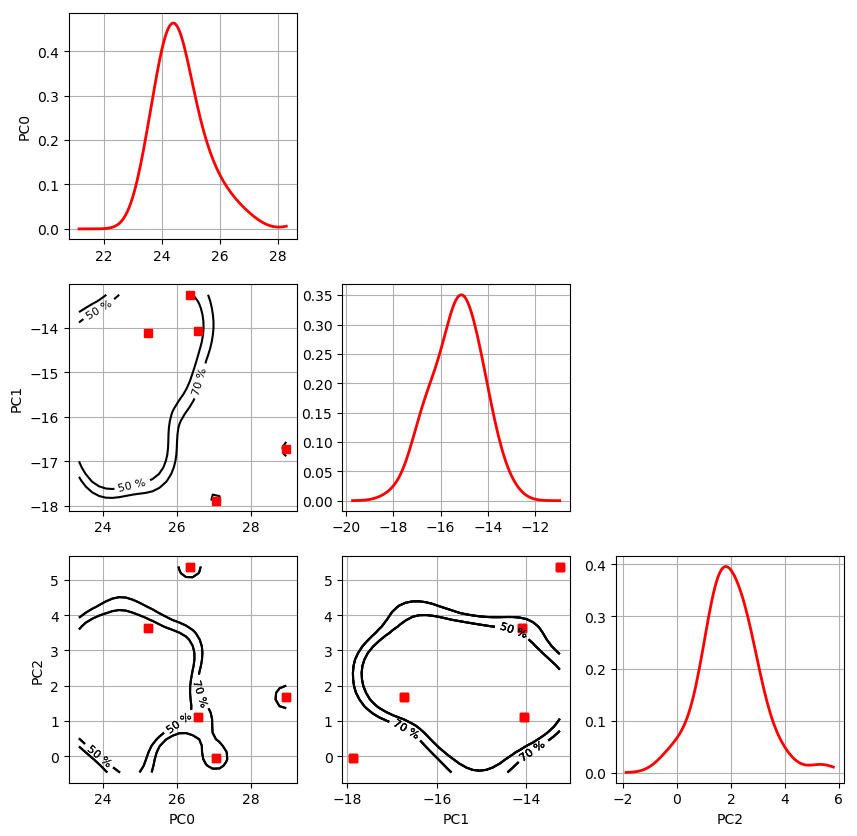

In [9]:
_ = hdr.drawDensity()

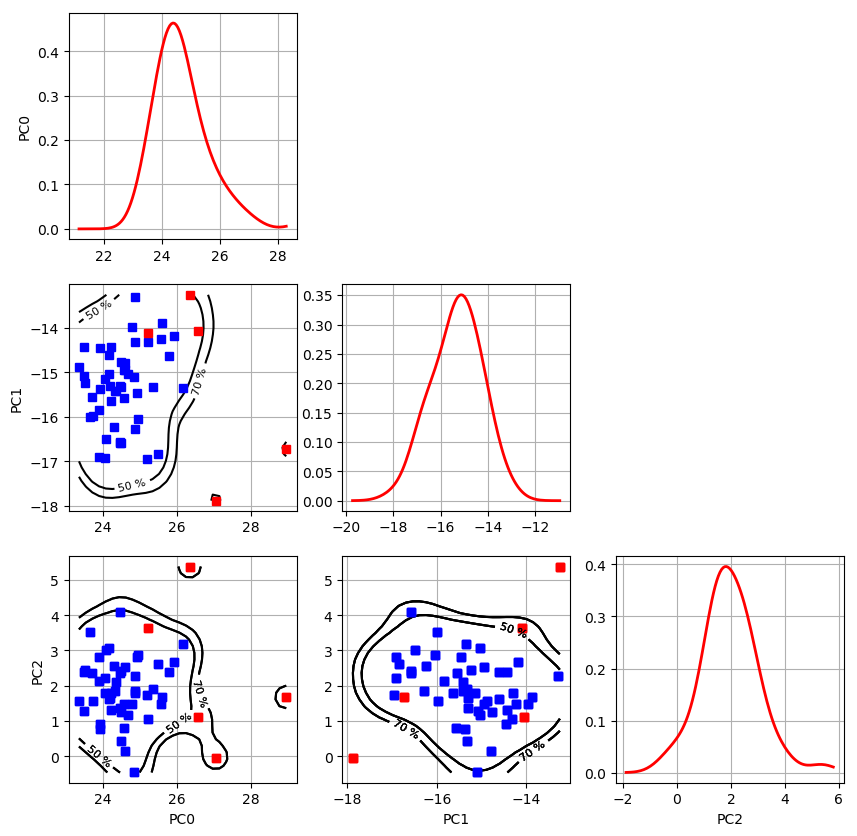

In [10]:
_ = hdr.drawDensity(drawData=True)

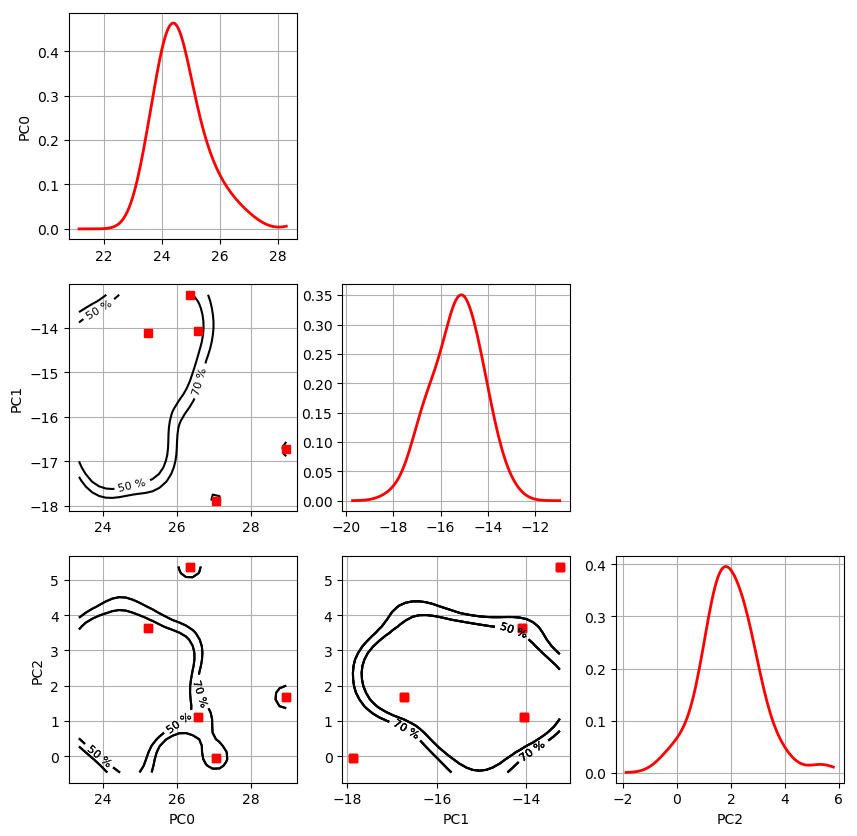

In [11]:
_ = hdr.drawDensity(drawOutliers=True)

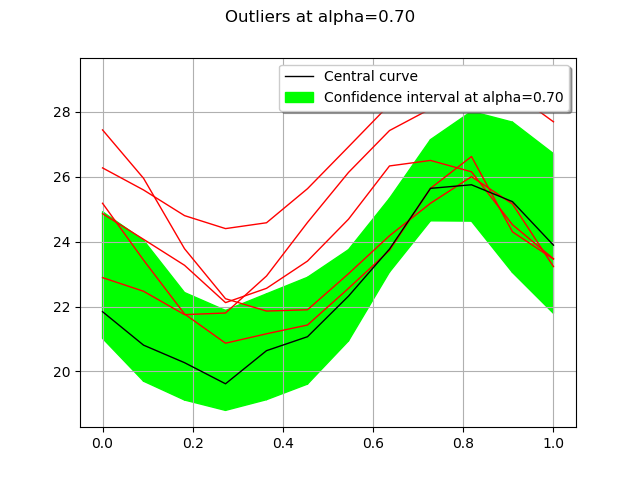

In [12]:
hdr.drawOutlierTrajectories()

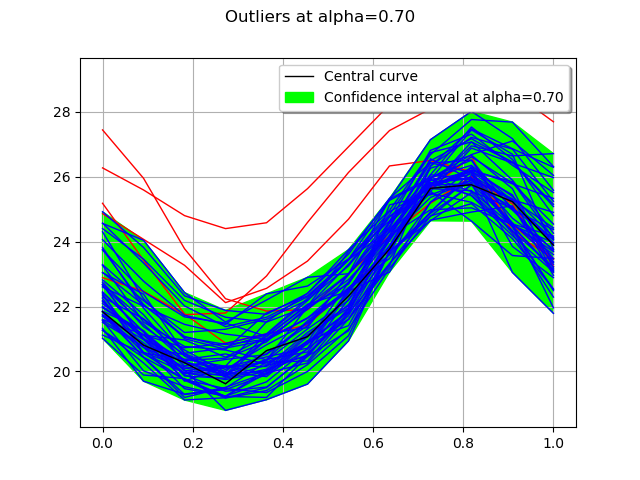

In [13]:
hdr.drawOutlierTrajectories(drawInliers=True)

In [14]:
print("Outliers trajectories at alpha=%.4f" % (hdr.densityPlot.outlierAlpha))
outlierIndices = hdr.computeOutlierIndices()
outlierIndices

Outliers trajectories at alpha=0.7000


[22, 32, 33, 47, 48]